# Titanic competition quick entry creation

Notebook for creating quick competition entries for the Titanic kaggle competition - this should be a concise way of training a model and outputting the csv files without the analysis carried out in the first two notebooks. 

This entry uses the full dataset with a separate validation set and keeps all the dependent variables available for each of the tree decisions, even if they appear to have no influence on the independent variable. 

It also includes the early processing of the training set and removes the feature extraction where an extra column was added to indicate whether a passenger was married or not. 

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [85]:
PATH = "data/titanic"
!ls tmp

keep_cols.npy	     titanic_processed_df_tandv
titanic_procdfd_raw  titanic_raw_cats


In [86]:

PATH = "data/titanic/"
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)


## Functions

In [87]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

In [88]:
def rmse(pred,actual): return math.sqrt(((pred-actual)**2).mean())

In [89]:
def print_score(m):
    '''
    Returns rmse and Rsquared scores on the training and validation sets,
    and provides an out of bag score if present
    '''
    result = [f'rmse train: {rmse(m.predict(x_train), y_train)} Training set size: {len(y_train)}', 
              f'\nrmse validation: {rmse(m.predict(x_valid), y_valid)} Validation set size: {len(y_valid)}',
              f'\nRsquared train: {m.score(x_train, y_train)}',
              f'\nRSquared valid: {m.score(x_valid, y_valid)}']
    print(result[0], result[1], result[2], result[3])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[4])

In [90]:
def custom_print_score(m, x_t, y_t):
    '''
    Allows use of the entire training set without separating out a validation set.
    This could be useful where a very small dataset is used, so that the validation set is
    not withheld from the training of the model. 
    Caution: A better solution might be to
    use a validation set then re-train the model on the entire training + validation set 
    once the hyperparameters are tuned. 
    '''
    result = [f'rmse train: {rmse(m.predict(x_t), y_t)} Total set size: {len(y_t)}', 
              f'\nRsquared train: {m.score(x_t, y_t)}']
    print(result[0], result[1])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[2])

In [91]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, 
                           "display.max_columns", 1000):
        display(df)

In [92]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right
    

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [93]:
# puts the predict function in a parent 
# function so it can be passed to parallel 
# trees and use all 4 cpus
def get_preds(t): 
    return t.predict(x_valid) 


## Train categories

In [94]:
train_cats(df_raw)
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/titanic_raw_cats')
df_raw = pd.read_feather('tmp/titanic_raw_cats')

#check for missing values:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

### Hyperparameters

In [95]:
set_rf_samples(700) # Number of passengers available to each tree 
# reset_rf_samples() # Set each tree to have access to all rows
n_estimators = 400 # Number of trees/estimators in model
min_samples_leaf = 3 # number remaining in each leaf node - average taken
max_features = 0.6 # For each decision , proportion of independent variables available.
max_n_cat = 5 # maximum number of categories to split categorical values into for one hot encoding.


## Process dataframe 
handle missing continuous variables, replace categories with their numeric codes and split the dependent variable out into a separate dataframe. 

In [96]:
df, y, nas = proc_df(df_raw, 'Survived', max_n_cat=max_n_cat)

In [97]:
#Saving
df.to_feather('tmp/titanic_processed_df_tandv')

In [98]:
#Loading
df = pd.read_feather('tmp/titanic_processed_df_tandv')

## Split the training set into a training and validation set

In [99]:
# n_valid = 418 #same as Kaggle's test set size
n_valid = 100 #smaller validation set to provide more training data
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
x_train, x_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

raw_train.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape


((791, 12), (791, 17), (791,), (100, 17), (100,))

### Train the model

In [100]:
#Training set and validation set scores
m = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

rmse train: 0.23614313438182905 Training set size: 791 
rmse validation: 0.32587668435534073 Validation set size: 100 
Rsquared train: 0.7649065935905992 
RSquared valid: 0.5390815390345903
OOB: 0.45827975860518944


In [103]:
feature_importance = rf_feat_importance(m,x_train);
feature_importance[:]

,cols,imp
10,Sex_female,0.191580
11,Sex_male,0.175696
6,Ticket,0.112303
2,Name,0.095781
3,Age,0.086806
7,Fare,0.084057
1,Pclass,0.075982
0,PassengerId,0.075611
8,Cabin,0.051767
4,SibSp,0.018872


## Decide which variables to keep and drop

In [104]:
to_drop = []

In [105]:
to_keep = feature_importance[feature_importance.imp>0.00].cols
df_keep = df[to_keep].copy()
df_keep.drop(to_drop, axis=1, inplace=True)

In [108]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))
print(f'There are {df_keep.columns.size} features left')

There are 15 features left


In [109]:
tree=m.estimators_[0].tree_
print(f'This tree has {dectree_max_depth(tree)} splits')

This tree has 18 splits


## Test the model's output with varying hyperparameter values 

### Hyperparameters
uncomment the code blocks below to see plots of varying hyperparameters

In [110]:
set_rf_samples(700) # Number of passengers available to each tree 
# reset_rf_samples() # Set each tree to have access to all rows
n_estimators = 400 # Number of trees/estimators in model
min_samples_leaf = 3 # number remaining in each leaf node - average taken
max_features = 0.6 # For each decision , proportion of independent variables available.
max_n_cat = 5 # maximum number of categories to split categorical values into for one hot encoding.


In [112]:
## n_estimators
# preds = np.stack([t.predict(x_valid) for t in m.estimators_])
# plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(200)])
## train the final model with 800-1000 estimators

#### rf sample pool size
in general increasing the points available for training increases the model's predictivity on the validation set. The model does not seem to be overfitting to the training set badly at all. 
<br>
<b>700-800 could be a good number of rf samples</b>

In [113]:
# def forest_prediction_samples(rf_samples):
#     set_rf_samples(rf_samples)
#     m = RandomForestRegressor(n_estimators=400, min_samples_leaf=1, n_jobs=-1, oob_score=True) 
#     m.fit(x_train, y_train)
#     preds = np.stack([t.predict(x_valid) for t in m.estimators_])
#     return preds
# plt.plot([metrics.r2_score(y_valid, np.mean(forest_prediction_samples(i)[:], axis=0)) for i in range(1,891,50)])
# plt.xlabel('increasing available samples - range 1-891')
# plt.ylabel('Rsquared score on validation set')
# plt.axis([0, 12, 0.4, 0.7])

#### minimum number of samples in each leaf node
We should pick 2 samples per leaf. 

Text(0, 0.5, 'Rsquared score on validation set')

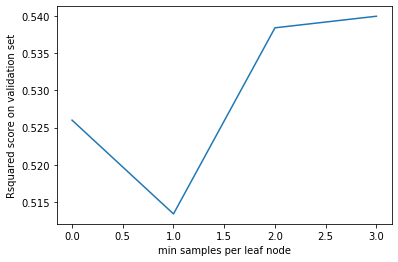

In [115]:
# def forest_prediction_samples_leaf(min_samples_leaf):
#     m = RandomForestRegressor(n_estimators=100, min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True) 
#     m.fit(x_train, y_train)
#     preds = np.stack([t.predict(x_valid) for t in m.estimators_])
#     return preds

# plt.plot([metrics.r2_score(y_valid, np.mean(forest_prediction_samples_leaf(i)[:], axis=0)) for i in range(1,5)])
# plt.xlabel('min samples per leaf node')
# plt.ylabel('Rsquared score on validation set')


In [60]:
# def forest_prediction_samples_leaf(min_samples_leaf):
#     m = RandomForestRegressor(n_estimators=40, min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True) 
#     m.fit(x_train, y_train)
#     preds = np.stack([parallel_trees(m, get_preds)]) # use parallel processing to speed things up
#     return preds

# plt.plot([metrics.r2_score(y_valid, np.mean(forest_prediction_samples_leaf(i)[:], axis=0)) for i in range(1, 3)])
# plt.xlabel('min samples per leaf node')
# plt.ylabel('Rsquared score on validation set')


#### Max features available per decision
Use somewhere between 70% and 90% of the features per decision. 

Text(0, 0.5, 'Rsquared score on validation set')

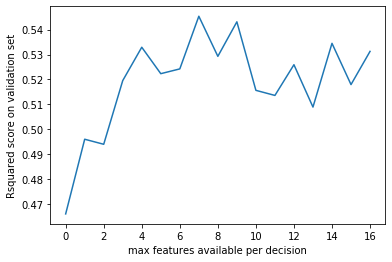

In [118]:
# def forest_prediction_max_features(max_features):
#     m = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, max_features=max_features, n_jobs=-1, oob_score=True) 
#     m.fit(x_train, y_train)
#     preds = np.stack([t.predict(x_valid) for t in m.estimators_])
#     return preds

# plt.plot([metrics.r2_score(y_valid, np.mean(forest_prediction_max_features(i)[:], axis=0)) for i in range(1, 18)])
# plt.xlabel('max features available per decision')
# plt.ylabel('Rsquared score on validation set')



## Train a more in depth model which takes longer to run

In [136]:
set_rf_samples(750) # Number of passengers available to each tree 
# reset_rf_samples() # Set each tree to have access to all rows
n_estimators = 2000 # Number of trees/estimators in model
min_samples_leaf = 3 # number remaining in each leaf node - average taken
max_features = 0.8 # For each decision , proportion of independent variables available.

In [137]:
m = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
custom_print_score(m, x_valid, y_valid)

rmse train: 0.3256202194257378 Total set size: 100 
Rsquared train: 0.5398067391542289
OOB: 0.46457644752643


## Combine the training and validation set and retrain the model
0.54 seems to be about the highest Rsquared score I can get with a split training and validation set. Combining the training and validation sets at this point will give more sample data but will remove the validation set so we can't check the Rsquared result anymore. 

In [219]:
final_model = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=-1, oob_score=True)
final_model.fit(df_keep, y)
custom_print_score(final_model, df_keep, y)

rmse train: 0.2323254316331369 Total set size: 891 
Rsquared train: 0.7717817015941706
OOB: 0.4746508130246877


## Load the testset

In [220]:
testset = pd.read_csv('data/titanic/test.csv')

In [221]:
train_cats(testset)

In [222]:
df_test, _ , nas_test = proc_df(testset, na_dict = nas,  max_n_cat=max_n_cat)

In [223]:
df_test_keep = df_test[to_keep]
df_test_keep.head()

,Sex_female,Sex_male,Ticket,Name,Age,Fare,Pclass,PassengerId,Cabin,SibSp,Embarked_S,Parch,Embarked_C,Age_na,Embarked_Q
0,0,1,153,207,34.5,7.8292,3,892,0,0,0,0,0,False,1
1,1,0,222,404,47.0,7.0000,3,893,0,1,1,0,0,False,0
2,0,1,74,270,62.0,9.6875,2,894,0,0,0,0,0,False,1
3,0,1,148,409,27.0,8.6625,3,895,0,0,1,0,0,False,0
4,1,0,139,179,22.0,12.2875,3,896,0,1,1,1,0,False,0


### Make predictions on the testset using our model

In [225]:
predictions = final_model.predict(df_test_keep)

In [226]:
# average predicted survival rate in the test cases
final_model.predict(df_test_keep).sum()/len(final_model.predict(df_test_keep))

0.40915625256588184

In [227]:
binary_predictions = [int(x) for x in (predictions.round())]

## Export the prediction data to a .CSV file

In [228]:
output = pd.DataFrame({"PassengerId" :df_test_keep.index+892, "Survived": binary_predictions})

In [229]:
output.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [230]:
output.to_csv('third_titanic_submission.csv', index=False)
print("Saved")

Saved
